In [1]:
# a notebook to check batch surface reactor in 2.6 vs. 3.1.0

In [48]:
import cantera as ct
import numpy as np
import scipy.signal
import os
import copy
import scipy.interpolate

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

print(ct.__version__)

2.6.0


In [46]:
# Pt111
# mech_yaml = '/home/moon/uncertainty_estimator/nam29_presentation/cpox_Pt/chem_annotated.yaml'
mech_yaml = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated.yaml'
# mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20251225/cantera/handbuilt3.yaml'
mech_yaml = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20251225/cantera/chem_annotated.yaml'

gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])

print(f'This mechanism contains {gas.n_species} gas species and {surf.n_species} surface species')
print(f'This mechanism contains {gas.n_reactions} gas reactions and {surf.n_reactions} surface reactions')

This mechanism contains 26 gas species and 23 surface species
This mechanism contains 97 gas reactions and 191 surface reactions


/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: StickingRate::validate: 
 Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
 at T = 10000.0

  


# Load an interpolation of temperature

In [47]:
pt_data = '/home/moon/uncertainty_estimator/cpox_pt/horn_data/pt_profiles_smooth.csv'
df = pd.read_csv(pt_data)

distances = (df['Distance (mm)'] - 10.0) / 1000.0  # ignore the 10mm of no/catalyst space
exp_Ts = df['Temperature (K)']

f = scipy.interpolate.interp1d(distances, exp_Ts, fill_value='extrapolate')

# plt.plot(distances, exp_Ts)

In [32]:
def get_i_thing(ref_composition, phase):
    for i in range(phase.n_species):
        if phase.species()[i].composition == ref_composition:
            return i
    assert False
    return -1

In [33]:
# Get indices of key species
i_Ar = get_i_thing({'Ar': 1.0}, gas)
i_CH4 = get_i_thing({'C': 1.0, 'H': 4.0}, gas)
i_O2 = get_i_thing({'O': 2.0}, gas)
i_CO2 = get_i_thing({'C': 1.0, 'O': 2.0}, gas)
i_H2O = get_i_thing({'H': 2.0, 'O': 1.0}, gas)
i_H2 = get_i_thing({'H': 2.0}, gas)
i_CO = get_i_thing({'C': 1.0, 'O': 1.0}, gas)
i_C2H4 = get_i_thing({'C': 2.0, 'H': 4.0}, gas)
i_X = get_i_thing({'X': 1.0}, surf)
i_OX = get_i_thing({'X': 1.0, 'O': 1.0}, surf)
i_HX = get_i_thing({'X': 1.0, 'H': 1.0}, surf)
i_CH3X = get_i_thing({'X': 1.0, 'H': 3.0, 'C': 1.0}, surf)

In [34]:
# Make the colors consistent between all mechanism
np.random.seed(400)
color_dict = {
    "{'X': 1.0}": '#1f77b4',
    "{'O': 1.0, 'X': 1.0}": '#ff7f0e',
    "{'H': 1.0, 'X': 1.0}": '#2ca02c',
    "{'H': 1.0, 'O': 1.0, 'X': 1.0}": '#d62728',
    "{'H': 1.0, 'N': 1.0, 'X': 1.0}": '#9467bd',
    "{'N': 1.0, 'O': 1.0, 'X': 2.0}": '#8c564b',
    "{'H': 3.0, 'N': 1.0, 'X': 1.0}": '#e377c2',
    "{'H': 2.0, 'N': 1.0, 'X': 1.0}": '#7f7f7f',
    "{'N': 2.0, 'X': 2.0}": '#bcbd22',
    "{'N': 1.0, 'X': 1.0}": '#17becf',
    "{'H': 2.0, 'X': 1.0}": '#1f77b4',
    "{'N': 2.0, 'X': 1.0}": '#ff7f0e',
    "{'H': 2.0, 'O': 1.0, 'X': 1.0}": '#2ca02c',
    "{'H': 2.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}": '#8c564b',
    "{'H': 3.0, 'N': 2.0, 'O': 1.0, 'X': 1.0}": '#9467bd',
    "{'H': 1.0, 'N': 1.0, 'O': 1.0, 'X': 2.0}": '#e377c2',
    "{'N': 1.0, 'O': 1.0, 'X': 1.0}": '#7f7f7f',
    "{'H': 1.0, 'N': 1.0, 'O': 1.0, 'X': 1.0}": '#bcbd22',
    "{'H': 2.0, 'N': 2.0, 'X': 1.0}": '#17becf'
}
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color(species):
    try:
        return color_dict[str(species.composition)]
    except KeyError:
        return colors[int(np.random.random() * len(colors))]

In [35]:
def increase_enthalpy(phase, species_index, increase_enthalpy_J_per_kmol):
    data_copy = copy.deepcopy(phase.species()[species_index].input_data)
    for i in range(len(data_copy['thermo']['data'])):
        data_copy['thermo']['data'][i][5] += increase_enthalpy_J_per_kmol / ct.gas_constant
    new_sp = ct.Species().from_dict(data_copy)
    phase.modify_species(species_index, new_sp)

In [36]:
#######################################################################
# Input Parameters
#######################################################################

N_reactors = 1001
T_in = 700
total_pfr_len = 0.1

individual_cstr_len = total_pfr_len / N_reactors
reactor_diameter = 0.0165
cross_section_area = (reactor_diameter / 2.0) ** 2.0 * np.pi
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 16000  # made-up
flow_rate = 4.7  # slpm
flow_rate = flow_rate * 0.001 / 60  # m^3/s
tot_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate / cross_section_area  # m/s

# The PFR will be simulated by a chain of 'NReactors' stirred reactors
# but we'll assume there's catalyst throughout the whole reactor
individual_cstr_vol = cross_section_area * individual_cstr_len * porosity

# catalyst area in one reactor
individual_cstr_cat_area = cat_area_per_vol * individual_cstr_vol

In [40]:
surf.species()[i_OX]

<Species OX(25)>

In [45]:
surf.reactions()[7]

H2O(5) + X(1) <=> H2OX(32)    <Reaction(sticking-Arrhenius)>

In [51]:
T = T_in

gas = ct.Solution(mech_yaml, 'gas')
surf = ct.Interface(mech_yaml, 'surface1', [gas])

x_CH4 = 0.296
x_O2 = 0.147
x_Ar = 1.0 - x_CH4 - x_O2

X = f'{gas.species_names[i_CH4]}: {x_CH4}, {gas.species_names[i_O2]}: {x_O2}, {gas.species_names[i_Ar]}: {x_Ar}'
print(X)
gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
mass_flow_rate = flow_rate * gas.density_mass
gas.TPX = T, ct.one_atm, X
surf.TP = T, ct.one_atm
print(mass_flow_rate)
initial_coverages = np.zeros_like(surf.coverages)
initial_coverages[i_X] = 1.0
surf.coverages = initial_coverages


# create a new reactor
r = ct.IdealGasReactor(gas, energy='off')
r.volume = individual_cstr_vol
upstream = ct.Reservoir(gas, name='upstream')
downstream = ct.Reservoir(gas, name='downstream')
rsurf = ct.ReactorSurface(surf, r, A=individual_cstr_cat_area)
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)
v = ct.PressureController(r, downstream, master=m, K=1e-5)
# v = ct.PressureController(r, downstream, primary=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
# sim.rtol = 1.0e-11
# sim.atol = 1.0e-20

# sim.rtol = 1.0e-10
# sim.atol = 1.0e-20

gas_names = gas.species_names
surf_names = surf.species_names
gas_out = []
surf_out = []
gas_rates = []
surf_rates = []
dist_array = np.linspace(0, total_pfr_len, N_reactors)
temperature_profile = f(dist_array)
T_array = []


# surf.set_multiplier(3e-7, 7)
surf.set_multiplier(0.0, 7)


for n in range(N_reactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = r.thermo.TDY
    upstream.syncState()
    
    gas.TDY = temperature_profile[n], r.thermo.DP[0], r.thermo.Y
#     surf.TD = temperature_profile[n], surf.TD[1]
    r.syncState()

    sim.reinitialize()
    sim.advance_to_steady_state()

    T_array.append(surf.T)
    # print "mass_flow_rate", mass_flow_rate,  v.mdot(sim.time), "kg/s"
    kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
    gas_out.append(1000 * 60 * kmole_flow_rate * gas.X.copy())  # molar flow rate in moles/minute
    surf_out.append(surf.X.copy())
    gas_rates.append(gas.net_rates_of_progress)
    surf_rates.append(surf.net_rates_of_progress)

gas_out = np.array(gas_out)
surf_out = np.array(surf_out)
gas_names = np.array(gas_names)
surf_names = np.array(surf_names)
gas_rates = np.array(gas_rates)
surf_rates = np.array(surf_rates)

/home/moon/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: StickingRate::validate: 
 Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
 at T = 5000.0

 Sticking coefficient is greater than 1 for reaction 'CH4(2) + 2 X(1) <=> CH3X(27) + HX(21)'
 at T = 10000.0

  after removing the cwd from sys.path.


CH4(2): 0.296, O2(3): 0.147, Ar: 0.5569999999999999
0.00011080258415087895


Text(0.5, 1.0, '2.6.0         1001 reactors')

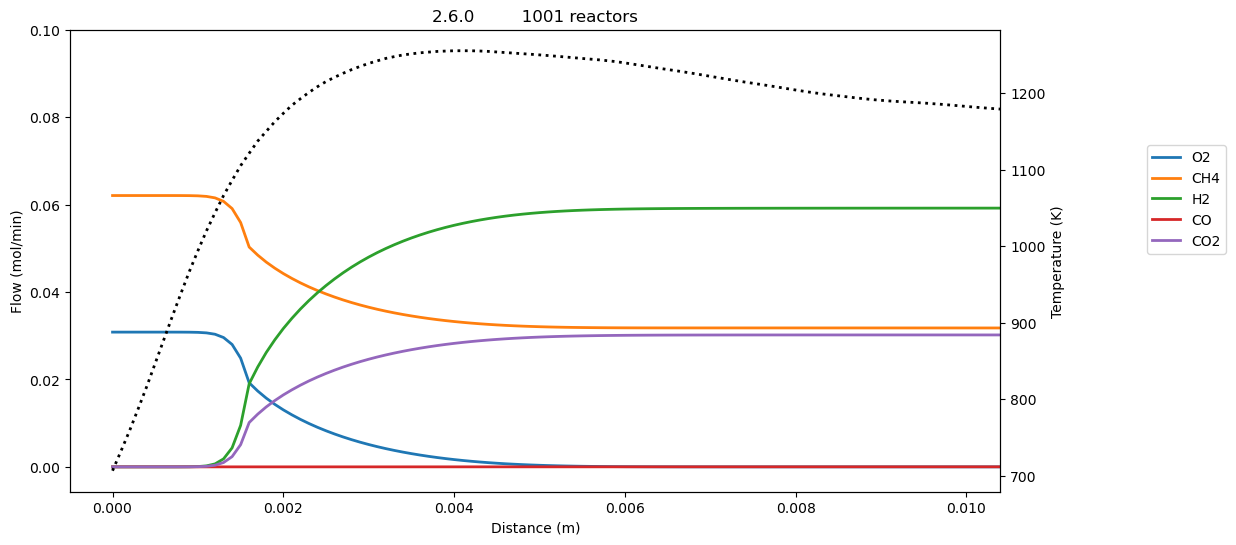

In [55]:
# Plot the result
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linewidth1 = 2.0
linewidth2 = 2.0

fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.plot(dist_array, gas_out[:, i_O2], label='O2', color=colors[0], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CH4], label='CH4', color=colors[1], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_H2], label='H2', color=colors[2], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO], label='CO', color=colors[3], linewidth=linewidth2)
plt.plot(dist_array, gas_out[:, i_CO2], label='CO2', color=colors[4], linewidth=linewidth2)


ax1 = plt.gca()
ylim = ax1.get_ylim()
# Mark the catalyst extent
# plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
# plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
plt.ylim(ylim)

ax2 = ax1.twinx()
ax2.plot(dist_array, T_array, label='Temperature', color='k', linestyle=':', linewidth=linewidth2)
ax2.set_ylabel('Temperature (K)')
# ax2.set_ylim((832.6458681304853, 1380.7048767073081))

ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.15, 0.5))
ax1.set_ylim((-0.005686988947011412, 0.1))
ax1.set_xlim((-0.0004950495049504951, 0.010396039603960397))

plt.title(ct.__version__ + f'         {N_reactors} reactors')

In [56]:
gas_out.shape

(1001, 26)

# Plot top gas-phase species

Text(0.5, 1.0, '2.6.0          PFR')

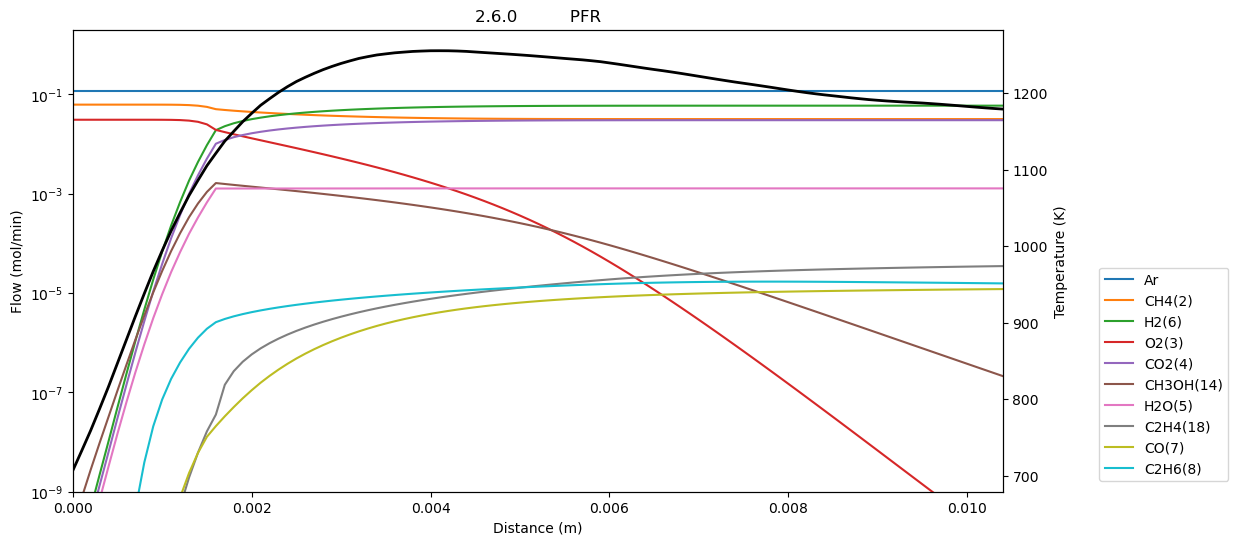

In [61]:
max_conc = np.max(gas_out, axis=0)
indices = np.arange(gas_out.shape[1])
sorted_order = [x for _, x in sorted(zip(max_conc, indices))][::-1]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)
for i in range(10):
    j = sorted_order[i]
    plt.plot(dist_array, gas_out[:, j], label=gas.species_names[j])

plt.ylabel('Gas concentration')
plt.xlabel('Distance (m)')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.yscale('log')
plt.ylim([1e-9, 2.0e0])

ax1 = plt.gca()
ax1.set_yscale('log')
ylim = ax1.get_ylim()
# Mark the catalyst extent
# plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
# plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
# plt.ylim(ylim)

ax2 = ax1.twinx()
ax2.plot(dist_array, T_array, label='Temperature', color='k', linestyle='solid', linewidth=linewidth2)

ax2.set_ylabel('Temperature (K)')
# ax2.set_ylim((832.6458681304853, 1380.7048767073081))

ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.25, 0.5))
# ax1.set_ylim((-0.005686988947011412, 0.11942676788723965))
ax1.set_xlim((0, 0.010396039603960397))

plt.title(ct.__version__ + f'          PFR')

# Plot top surface-phase species

Text(0.5, 1.0, '2.6.0          PFR')

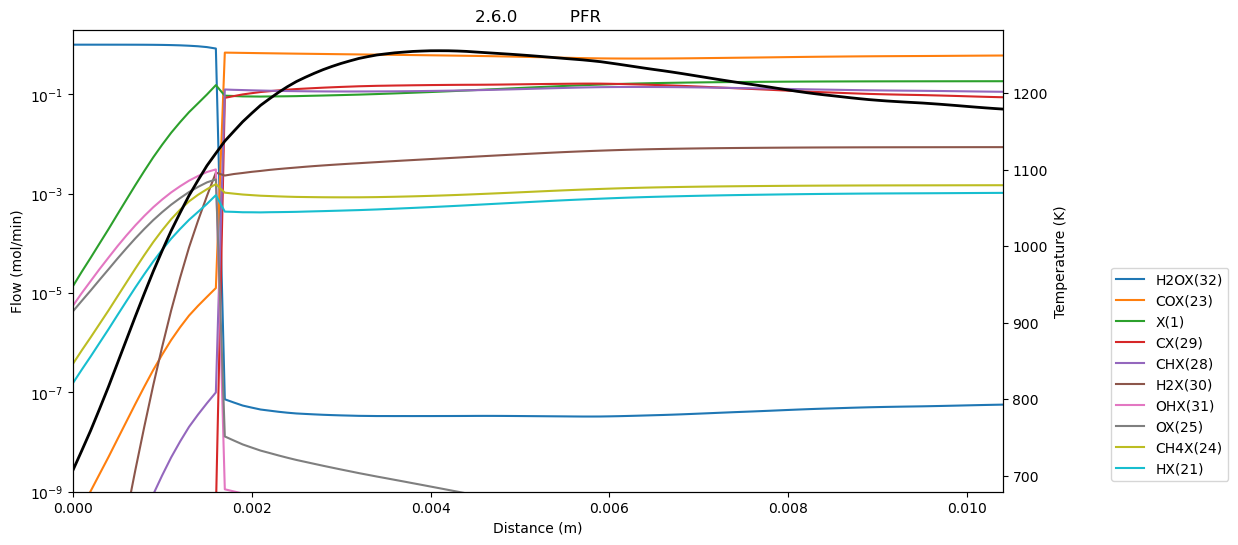

In [63]:
max_conc = np.max(surf_out, axis=0)
indices = np.arange(surf_out.shape[1])
sorted_order = [x for _, x in sorted(zip(max_conc, indices))][::-1]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)
for i in range(10):
    j = sorted_order[i]
    plt.plot(dist_array, surf_out[:, j], label=surf.species_names[j])

plt.ylabel('Surface concentration')
plt.xlabel('Distance (m)')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.yscale('log')
plt.ylim([1e-9, 2.0e0])

ax1 = plt.gca()
ax1.set_yscale('log')
ylim = ax1.get_ylim()
# Mark the catalyst extent
# plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
# plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.0], linestyle='--', color='xkcd:grey')
# plt.ylim(ylim)

ax2 = ax1.twinx()
ax2.plot(dist_array, T_array, label='Temperature', color='k', linestyle='solid', linewidth=linewidth2)

ax2.set_ylabel('Temperature (K)')
# ax2.set_ylim((832.6458681304853, 1380.7048767073081))

ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Flow (mol/min)')
ax1.legend(bbox_to_anchor=(1.25, 0.5))
# ax1.set_ylim((-0.005686988947011412, 0.11942676788723965))
ax1.set_xlim((0, 0.010396039603960397))

plt.title(ct.__version__ + f'          PFR')